In [1]:
%matplotlib inline
import functools
import itertools
import multiprocess as mp

import modin.pandas as pd
from tqdm.notebook import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt

import edgedroid.data as e_data
import edgedroid.util as util
from edgedroid.execution_times import *
from mpl_toolkits import mplot3d

raw_data_params = e_data.load_default_exec_time_data()
data = preprocess_data(*raw_data_params)
raw_data, *_ = raw_data_params
data

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration
0,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)"
1,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)"
2,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)"
3,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)"
4,134146,5,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[5.0, 10.0)"
...,...,...,...,...,...,...,...
6715,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,Higher2Lower,"[5.0, 10.0)"
6716,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,Higher2Lower,"[5.0, 10.0)"
6717,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,Higher2Lower,"[10.0, inf)"
6718,137353,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,Higher2Lower,"[10.0, inf)"


In [2]:
raw_data

,run_id,seq,exec_time,delay,neuroticism
0,134146,1,4.433,0.0,0.375
1,134146,2,2.956,0.0,0.375
2,134146,3,5.443,0.0,0.375
3,134146,4,5.206,0.0,0.375
4,134146,5,4.783,0.0,0.375
...,...,...,...,...,...
6715,137353,164,6.501,0.0,0.625
6716,137353,165,4.722,0.0,0.625
6717,137353,166,3.475,0.0,0.625
6718,137353,167,2.296,0.0,0.625


In [3]:
# generate data for model

num_traces = 100
run_ids = raw_data.run_id.unique()
run_len = len(raw_data[raw_data.run_id == np.random.choice(run_ids)].index)

with mp.Pool() as pool:
    dfs = deque()

    for model_cls in (TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel):
        model_name = model_cls.__name__

        for participant in tqdm(run_ids, desc=model_name, leave=True):
            raw_delays = raw_data[raw_data.run_id == participant].delay
            neuro = raw_data[raw_data.run_id == participant].neuroticism.values[0]

            # model = model_cls(data=data, neuroticism=neuro)
            for j, trace in enumerate(
                pool.imap(
                    lambda t: util.gen_model_trace(delays=t[0], model=t[1](data=t[2], neuroticism=t[3])),
                    zip(
                        itertools.repeat(raw_delays, num_traces),
                        itertools.repeat(model_cls),
                        itertools.repeat(data),
                        itertools.repeat(neuro)
                    )
                )
            ):
                trace["run_id"] = participant
                trace.index = trace.index.set_names(["step_index"])
                trace["model"] = model_name
                dfs.append(trace.reset_index())

results = pd.concat(dfs, ignore_index=True)

TheoreticalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

EmpiricalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
results

,step_index,model neuroticism,model neuroticism (binned),latest impairment,latest transition,current duration,current duration (binned),exec_time,delay,run_id,model
0,0,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,0,"[0.0, 5.0)",5.153044,NaN,134146,TheoreticalExecutionTimeModel
1,1,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,1,"[0.0, 5.0)",7.695080,0.0,134146,TheoreticalExecutionTimeModel
2,2,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,2,"[0.0, 5.0)",7.041809,0.0,134146,TheoreticalExecutionTimeModel
3,3,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,3,"[0.0, 5.0)",7.954576,0.0,134146,TheoreticalExecutionTimeModel
4,4,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,4,"[0.0, 5.0)",2.224022,0.0,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...,...,...,...
1351995,164,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,8,"[5.0, 10.0)",5.812000,0.0,137353,EmpiricalExecutionTimeModel
1351996,165,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,9,"[5.0, 10.0)",2.547000,0.0,137353,EmpiricalExecutionTimeModel
1351997,166,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,10,"[10.0, inf)",2.569000,0.0,137353,EmpiricalExecutionTimeModel
1351998,167,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,11,"[10.0, inf)",2.246000,0.0,137353,EmpiricalExecutionTimeModel


In [5]:
df1 = results.drop(columns=[col for col in results.columns
                      if col not in ['step_index', 'model neuroticism (binned)',
                      'latest impairment', 'latest transition', 'run_id',
                      'current duration (binned)', 'exec_time', 'model']])\
    .rename(columns={
        'step_index': 'seq',
        'model neuroticism (binned)': 'neuroticism',
        'latest impairment': 'impairment',
        'latest transition': 'transition',
        'current duration (binned)': 'duration',
        'exec_time': 'next_exec_time'
    }
)
df1

,seq,neuroticism,impairment,transition,duration,next_exec_time,run_id,model
0,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",5.153044,134146,TheoreticalExecutionTimeModel
1,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.695080,134146,TheoreticalExecutionTimeModel
2,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.041809,134146,TheoreticalExecutionTimeModel
3,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.954576,134146,TheoreticalExecutionTimeModel
4,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",2.224022,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...
1351995,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[5.0, 10.0)",5.812000,137353,EmpiricalExecutionTimeModel
1351996,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[5.0, 10.0)",2.547000,137353,EmpiricalExecutionTimeModel
1351997,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[10.0, inf)",2.569000,137353,EmpiricalExecutionTimeModel
1351998,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[10.0, inf)",2.246000,137353,EmpiricalExecutionTimeModel


In [6]:
df2 = data.copy()
df2["seq"] -= 1
df2["model"] = "Underlying data"

df2

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration,model
0,134146,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)",Underlying data
1,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)",Underlying data
2,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)",Underlying data
3,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)",Underlying data
4,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[5.0, 10.0)",Underlying data
...,...,...,...,...,...,...,...,...
6715,137353,163,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,Higher2Lower,"[5.0, 10.0)",Underlying data
6716,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,Higher2Lower,"[5.0, 10.0)",Underlying data
6717,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,Higher2Lower,"[10.0, inf)",Underlying data
6718,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,Higher2Lower,"[10.0, inf)",Underlying data


In [7]:
df = pd.concat((df1, df2), ignore_index=True)
df

,seq,neuroticism,impairment,transition,duration,next_exec_time,run_id,model
0,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",5.153044,134146,TheoreticalExecutionTimeModel
1,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.695080,134146,TheoreticalExecutionTimeModel
2,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.041809,134146,TheoreticalExecutionTimeModel
3,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.954576,134146,TheoreticalExecutionTimeModel
4,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",2.224022,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...
1358715,163,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[5.0, 10.0)",4.722000,137353,Underlying data
1358716,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[5.0, 10.0)",3.475000,137353,Underlying data
1358717,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[10.0, inf)",2.296000,137353,Underlying data
1358718,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,"[10.0, inf)",4.608000,137353,Underlying data


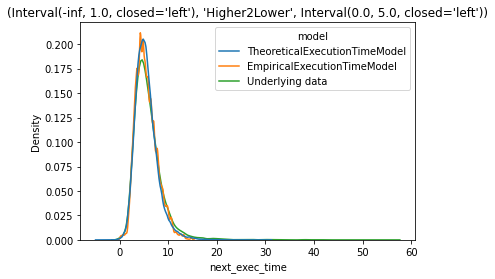

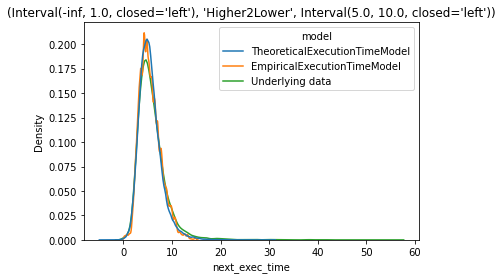

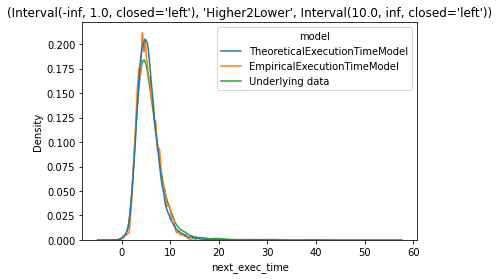

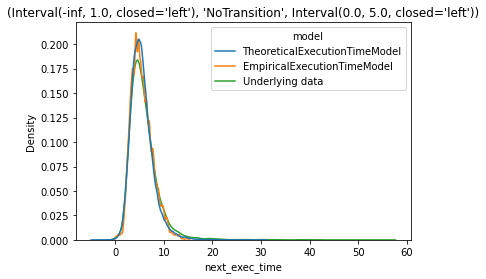

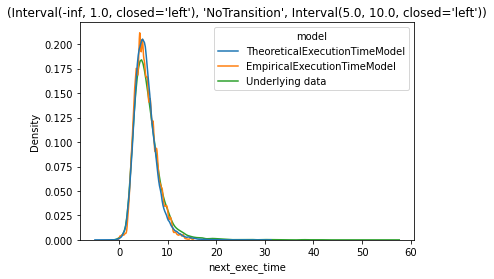

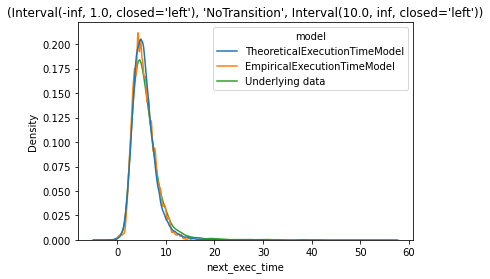

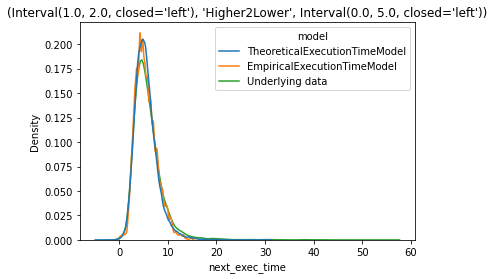

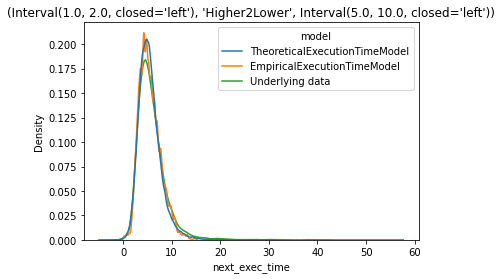

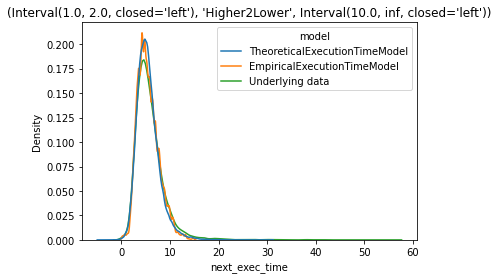

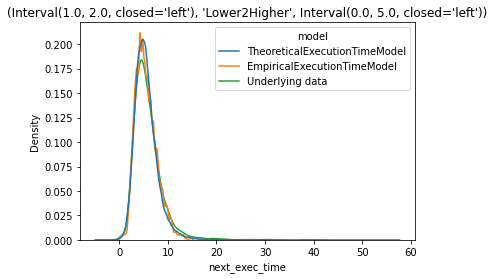

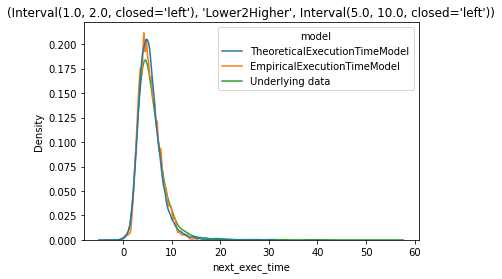

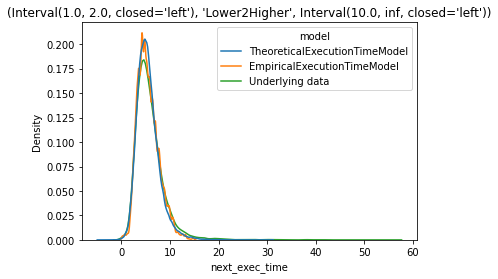

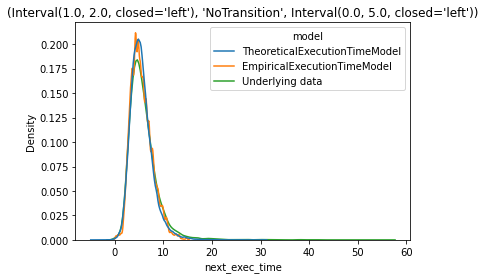

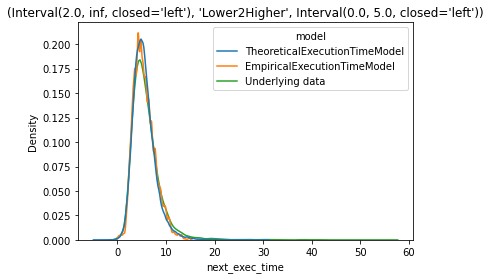

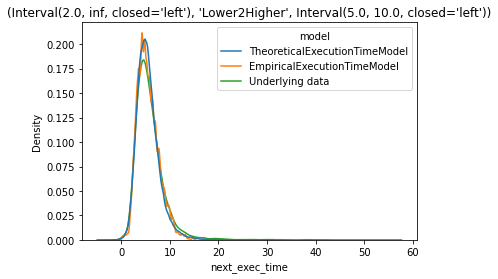

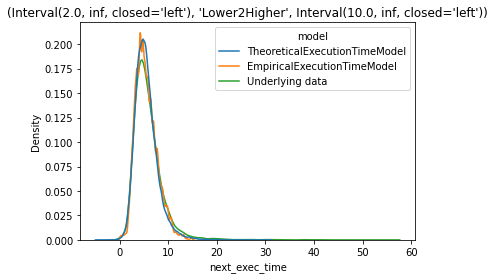

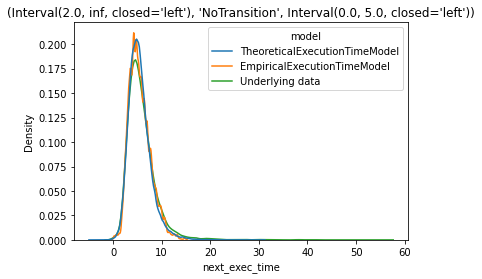

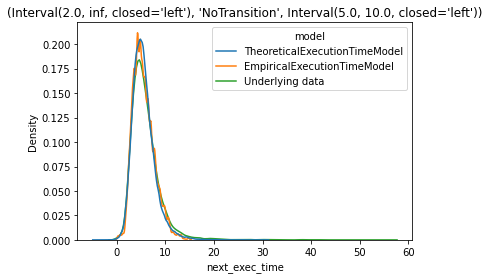

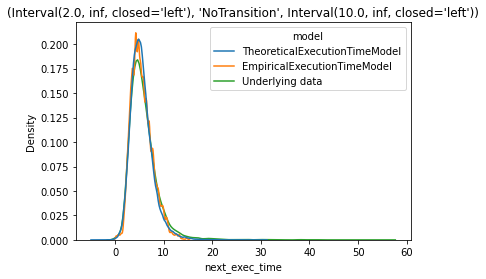

In [8]:
for g, df_sg in df.groupby(['impairment', 'transition', 'duration']):
    ax = sns.kdeplot(
        # kind='kde',
        data=df,
        x='next_exec_time',
        hue='model',
        # cumulative=True,
        common_norm=False
    )
    ax.set_title(str(g))
    plt.show()

In [9]:
# randomly sample participant, compare with model, repeat

samples = 100
run_ids = raw_data.run_id.unique()
rng = np.random.default_rng()

dfs = deque()

for model_cls in tqdm((EmpiricalExecutionTimeModel, TheoreticalExecutionTimeModel), desc="Models"):
    model_name = model_cls.__name__

    pbar = trange(samples)
    pbar.set_description(f"Samples for model {model_name}")
    for si in pbar:
        run = rng.choice(run_ids)
        df = raw_data[raw_data.run_id == run]

        # df holds data for a single participant
        delays = df.delay.values
        neuro = df.neuroticism.values[0]
        exec_times = np.concatenate((df.exec_time, np.array([np.nan])))

        model = model_cls(data=data, neuroticism=neuro)
        trace = util.gen_model_trace(delays, model)

        trace["exec_time_rel"] = trace.exec_time / exec_times
        trace["run_id"] = run
        trace["sample"] = si
        trace["model"] = model_name
        dfs.append(trace)

trace_data = pd.concat(dfs, ignore_index=True)

Models:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

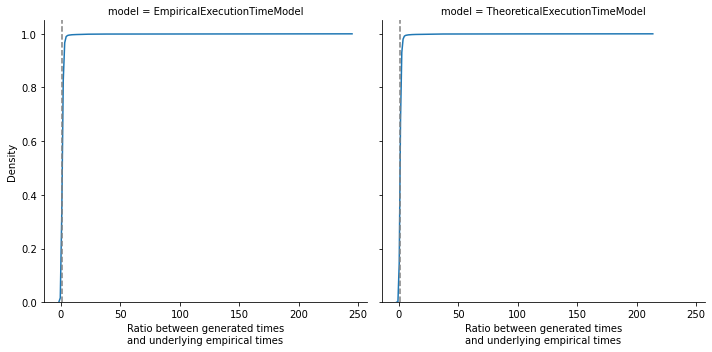

In [10]:
fg = sns.displot(
    kind="kde",
    data=trace_data,
    x="exec_time_rel",
    common_norm=False,
    col="model",
    cumulative=True
)
fg.set_xlabels("Ratio between generated times\nand underlying empirical times")
fg.refline(x=1)
plt.show()

In [11]:
trace_data.groupby("model")["exec_time_rel"].describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.99, 0.999])

,count,mean,std,min,10%,25%,50%,75%,99%,99.9%,max
model,,,,,,,,,,,
EmpiricalExecutionTimeModel,16800.0,1.280754,4.219331,0.005369,0.443278,0.644986,0.970597,1.420867,4.151287,31.798685,243.031250
TheoreticalExecutionTimeModel,16800.0,1.253673,3.418905,-0.397038,0.445259,0.651179,0.960050,1.406012,4.172475,29.675527,212.122465
